# Estudo de Caso: Análise de Filmes para a PProductions

**Objetivo:** Analisar uma base de dados de filmes do IMDb para extrair insights e construir um modelo preditivo que oriente as decisões de produção do estúdio PProductions.

Esta análise revela que o sucesso financeiro está fortemente ligado à popularidade do filme e a gêneros como Ação/Aventura. Com base nisso, foi construído um modelo de regressão com um erro médio de apenas 0.21 pontos na escala IMDb para prever a qualidade de futuras produções.

### Carregamento das bibliotecas necessárias e da base de dados
Nesta primeira etapa, vamos importar as principais bibliotecas que serão utilizadas ao longo do projeto e carregar o conjunto de dados a ser analisado.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import joblib

In [2]:
# Importando os dados do Dataframe
data_movies = pd.read_csv('desafio_indicium_imdb.csv' )

# Verificando informações gerais e tipos de dados
data_movies.head()
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


Após uma análise rápida dos dados raw, pude notar que haviam dados ausentes nas colunas `Certificate`, `Meta_score` e `Gross`, que indicam respectivamente as informações sobre **Classificação Etária**, **Média Ponderada de Todas as Críticas**, e **Faturamento** dos filmes analisados. Além disso, percebi que algumas colunas que deveriam conter valores numéricos (*float, int*), na verdade continham valores considerados como texto (*object*). São elas as colunas `Released_Year`, `Runtime` e `Gross`.

Por isso, foi necessária a limpeza e organização dos dados, além de transformar em valores numéricos os valores *object* de colunas numéricas.

Porém, ao tentar realizar a limpeza dos dados, descobri que algum dado da coluna `Released_Year` não era numérico, e que na verdade pertencia à coluna `Certificate` que está relacionada à faixa etária indicativa de cada filme.

Por esse motivo, optei por corrigir esses dados antes de efetuar a limpeza das colunas de fato.

In [3]:
data_movies[data_movies['Released_Year'] == 'PG']

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
965,966,Apollo 13,PG,U,140 min,"Adventure, Drama, History",7.6,NASA must devise a strategy to return Apollo 1...,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,Gary Sinise,269197,"173,837,933"


In [4]:
# Consertando os valores da linha 965
data_movies.loc[965, 'Released_Year'] = 1995
data_movies.loc[965, 'Certificate'] = 'PG'

In [5]:
# Limpeza e organização dos dados
data_movies['Runtime'] = data_movies['Runtime'].str.replace(' min', '').astype(int)
data_movies['Gross'] = data_movies['Gross'].str.replace(',', '')
data_movies['Released_Year'] = data_movies['Released_Year'].astype(int)

print(data_movies.head())

   Unnamed: 0                                   Series_Title  Released_Year  \
0           1                                  The Godfather           1972   
1           2                                The Dark Knight           2008   
2           3                         The Godfather: Part II           1974   
3           4                                   12 Angry Men           1957   
4           5  The Lord of the Rings: The Return of the King           2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A      175              Crime, Drama          9.2   
1          UA      152      Action, Crime, Drama          9.0   
2           A      202              Crime, Drama          9.0   
3           U       96              Crime, Drama          9.0   
4           U      201  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...       100.0  

Pelo que pude observar nos dados da coluna `Gross`, os valores ausentes estão  a filmes independentes, filmes estrangeiros (não-Hollywoodianos) e/ou filmes muito antigos, ou ainda, obras que foram lançados diretamente em plataformas de streaming, ou seja, não tiveram arrecadação através da bilheteria do cinema.

Por esse motivo, optei por remover essas linhas, garantindo que a análise de faturamento seja feita apenas com os filmes para os quais essa informação é realmente relevante.

In [6]:
# Removendo valores missing da coluna Gross e convertendo em numérica
data_movies = data_movies.dropna(subset=['Gross'])
data_movies['Gross'] = data_movies['Gross'].astype(int)

Ao analisar os valores missing, pude notar que a maioria dos valores ausentes na coluna `Meta_score` também estavam ausentes na coluna `Gross`, ou tinham um baixo faturamento. Então, eu optei por remover essas linhas.

In [7]:
# Removendo valores missing da coluna Meta_score e convertendo em numérica
data_movies = data_movies.dropna(subset=['Meta_score'])
data_movies['Meta_score'] = data_movies['Meta_score'].astype(int)

Faltando apenas uma coluna com dados nulos: `Certificate` (a classificação indicativa). Por ser uma coluna de texto, para os filmes que não têm essa classificação, resolvi preencher os valores nulos com o texto padrão, "Não Classificado".

In [8]:
# Substituindo os valores missing da coluna Certificate por "Não Classificado"
data_movies['Certificate'] = data_movies['Certificate'].fillna('Não Classificado')

In [9]:
data_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749 entries, 0 to 996
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     749 non-null    int64  
 1   Series_Title   749 non-null    object 
 2   Released_Year  749 non-null    int64  
 3   Certificate    749 non-null    object 
 4   Runtime        749 non-null    int64  
 5   Genre          749 non-null    object 
 6   IMDB_Rating    749 non-null    float64
 7   Overview       749 non-null    object 
 8   Meta_score     749 non-null    int64  
 9   Director       749 non-null    object 
 10  Star1          749 non-null    object 
 11  Star2          749 non-null    object 
 12  Star3          749 non-null    object 
 13  Star4          749 non-null    object 
 14  No_of_Votes    749 non-null    int64  
 15  Gross          749 non-null    int64  
dtypes: float64(1), int64(6), object(9)
memory usage: 99.5+ KB


## Análise Exploratória de Dados (EDA) e Insights de Negócio
Com os dados limpos, agora é hora de responder às perguntas do estúdio PProductions.



### Qual filme você recomendaria para uma pessoa que você não conhece?

Estratégia: Encontrar um filme com aclamação universal, ou seja, altas notas tanto do público quanto da crítica.

In [10]:
# Filtrando os filmes com IMDB_Rating maior que 8.5 e Meta_score maior que 85

data_movies[(data_movies['IMDB_Rating'] > 8.5) & (data_movies['Meta_score'] > 85)]

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411
2,3,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000
3,4,12 Angry Men,1957,U,96,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000
4,5,The Lord of the Rings: The Return of the King,2003,U,201,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,377845905
5,6,Pulp Fiction,1994,A,154,"Crime, Drama",8.9,"The lives of two mob hitmen, a boxer, a gangst...",94,Quentin Tarantino,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,1826188,107928762
6,7,Schindler's List,1993,A,195,"Biography, Drama, History",8.9,"In German-occupied Poland during World War II,...",94,Steven Spielberg,Liam Neeson,Ralph Fiennes,Ben Kingsley,Caroline Goodall,1213505,96898818
9,10,The Lord of the Rings: The Fellowship of the Ring,2001,U,178,"Action, Adventure, Drama",8.8,A meek Hobbit from the Shire and eight compani...,92,Peter Jackson,Elijah Wood,Ian McKellen,Orlando Bloom,Sean Bean,1661481,315544750
11,12,"Il buono, il brutto, il cattivo",1966,A,161,Western,8.8,A bounty hunting scam joins two men in an unea...,90,Sergio Leone,Clint Eastwood,Eli Wallach,Lee Van Cleef,Aldo Giuffrè,688390,6100000
12,13,The Lord of the Rings: The Two Towers,2002,UA,179,"Action, Adventure, Drama",8.7,While Frodo and Sam edge closer to Mordor with...,87,Peter Jackson,Elijah Wood,Ian McKellen,Viggo Mortensen,Orlando Bloom,1485555,342551365
14,15,Goodfellas,1990,A,146,"Biography, Crime, Drama",8.7,The story of Henry Hill and his life in the mo...,90,Martin Scorsese,Robert De Niro,Ray Liotta,Joe Pesci,Lorraine Bracco,1020727,46836394


Para responder a essa perguntar, eu filtrei os filmes com avaliações maiores 8.5 pelo público (`IMDB_Rating`) e avaliações maiores que 85 pela crítica (`Meta_score`).

Dentre os filmes da lista resultante dessa filtragem, eu recomendaria o longa da linha 18, *Gisaengchung*, mais conhecido como **Parasita**, filme Sul-Coreano de 2019, vencedor do Oscar de Melhor Filme Estrangeiro, Melhor Diretor para o diretor Bong Joon Ho, Melhor Roteiro Original e Melhor Filme em 2020. O filme tem comédia, drama, suspense, com reviravoltaas surpreendentes.

O longa acompanha A família Kim, uma familia pobre que enfrenta dificuldades e vê uma oportunidade de melhorar de vida quando o filho começa a trabalhar para a rica família Park. Logo, todos eles encontram uma maneira de trabalhar na mesma casa e passam a levar uma vida parasitária.

## Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?

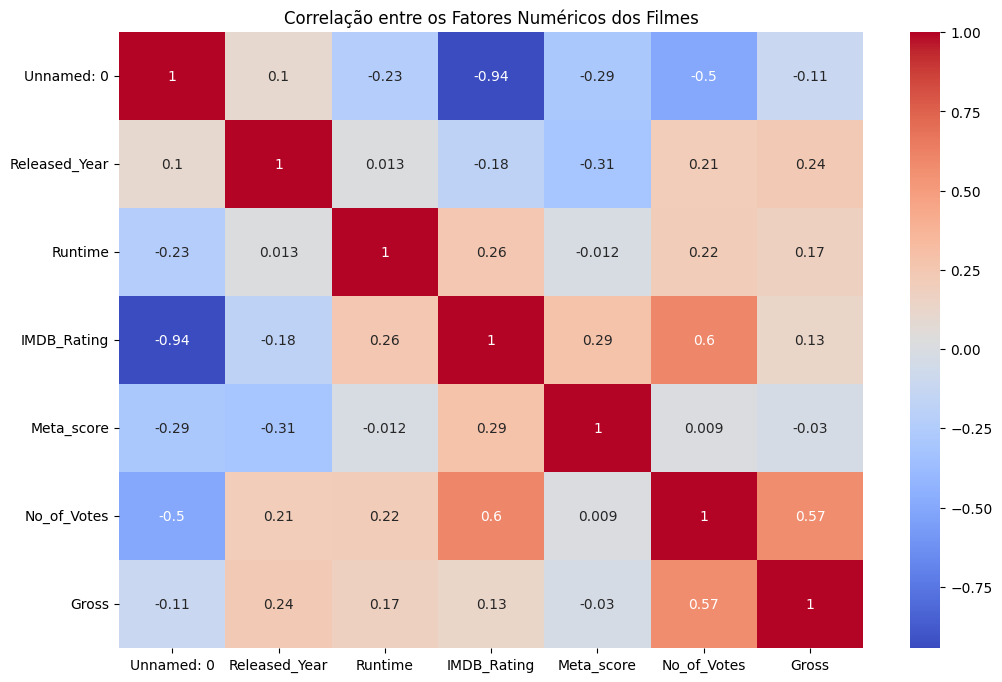

In [23]:
# Calculando os dados de correlação utilizando apenas colunas numéricas
movies_numbers = data_movies.select_dtypes(include='number')
movie_corr = movies_numbers.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(movie_corr, annot=True, cmap='coolwarm')
plt.title('Correlação entre os Fatores Numéricos dos Filmes')
plt.show()

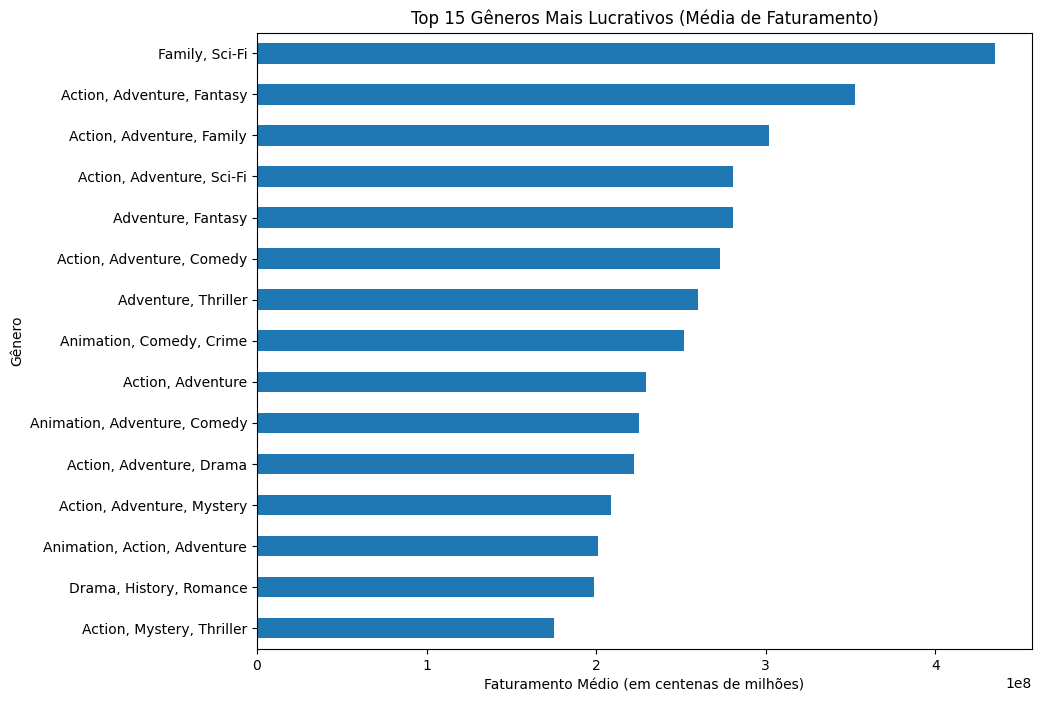

In [12]:
# Calculando quais gêneros ttêm mais faturamento
generos_lucrativos = data_movies.groupby('Genre')['Gross'].mean().sort_values(ascending=False)

# Gráfico com os 15 títulos mais lucrativos
plt.figure(figsize=(10, 8))
generos_lucrativos.head(15).plot(kind='barh').invert_yaxis()
plt.title('Top 15 Gêneros Mais Lucrativos (Média de Faturamento)')
plt.xlabel('Faturamento Médio (em centenas de milhões)')
plt.ylabel('Gênero')
plt.show()

Para responder a essa pergunta, fiz uma matriz de correlação para analisar quais fatores estão correlacionados a um alto faturamento, e o que eu pude extrair dessa análise foi que filmes que geram um alto nível de engajamento do público tem um alto faturamento, vide a alta correlação entre `No_of_Votes` e `Gross`.

Por isso, resolvi analisar quais gêneros faturam mais. Através da análise, podemos observar que gêneros mistos são os que faturam mais, e dentre eles, os 5 gêneros com maior faturamento da lista são uma mistura de: Ação, Aventura, ficção Científica (Sci-Fi), Fantasia e Família.

Ou seja, filmes de grande espetáculo, como aventuras, ação e ficção científica com apelo familiar, são os que geram as maiores médias de bilheteria.

## Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

In [13]:
# Juntando todos os resumos em um único texto mais completo.
texto_completo = ' '.join(resumo for resumo in data_movies.Overview)

print("Texto preparado com sucesso!")

Texto preparado com sucesso!


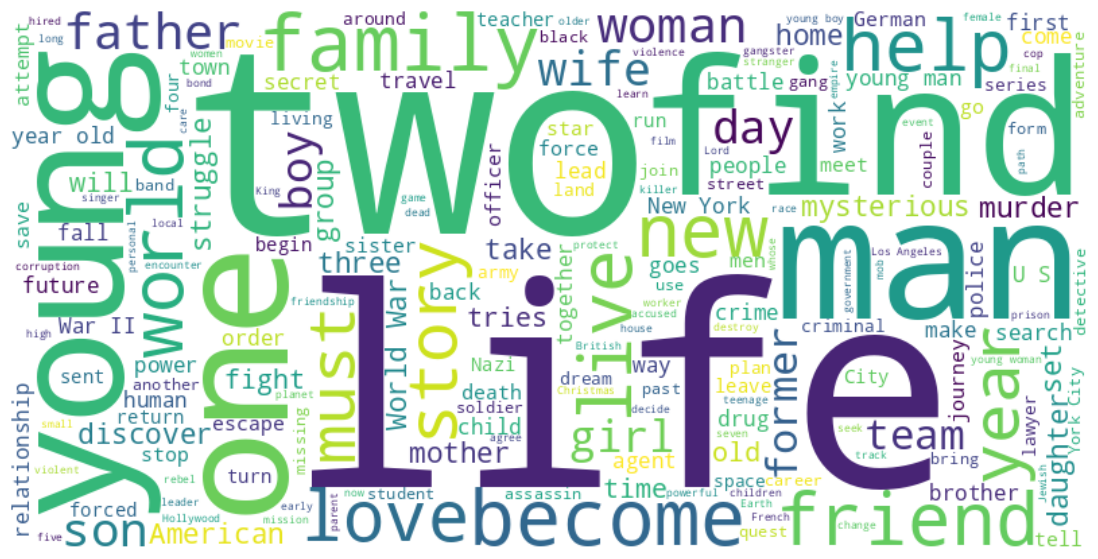

In [14]:
# Criando a Nuvem de Palavras
wordcloud = WordCloud(background_color="white", width=800, height=400).generate(texto_completo)

# Exibindo a Nuvem de Palavras
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

A resposta para essas 2 perguntas precisam ser dividas em 2 partes:

* **Parte 1: Insights obtidos através da coluna `Overview`**

    Para obter esses insights, precisei gerar uma nuvem de palavras-chaves, onde quanto maior a relevância da palavra (número de vezes que ela aparece na coluna `Overview`), maior o tamanho da fonte utilizada para visualização essa palavra.
    A partir disso, podemos observar que as palavras *life* (vida), *find* (encontrar), *man* (homem), *two* (dois), *young* (jovem), *world* (mundo), *woman* (mulher) e *family* (família) têm as maiores fontes, e portanto, são as palavras que mais se repetem nos resumos dos filmes.

    Basicamente, essa nuvem de palavras mostra de forma muito clara que as histórias de maior destaque neste dataset (que é de filmes aclamados) são profundamente humanas e universais.

    Ou seja, roteiros com um núcleo emocional forte e com temas que se conectam com a experiência humana, histórias focadas na jornada de um indivíduo ou de uma família, suas lutas e relacionamentos, têm um apelo imenso e são a base de muitos filmes de sucesso.

* **Parte 2: Possibilidade de inferir o gênero do filme a partir da coluna `Overview`**

    Sim, é possível prever o gênero de um filme a partir da coluna `Overview`.
    Isso é feito como um problema de classificação de texto em Machine Learning, onde o objetivo é atribuir uma ou mais categorias (gêneros) a cada filme com base no seu texto.

    1- **Pré-processamento do texto**: É feita a limpeza e padronização dos resumos (letras minúsculas, sem pontuação, sem palavras irrelevantes). Isso garante que o modelo foque apenas no conteúdo útil.

    2- **Vectorização com TF-IDF**: Como modelos de Machine Learning não interpretam texto, seria necessário converter o texto em números, destacando palavras importantes para diferenciar gêneros (ex.: “espaçonave” indica ficção científica).

    3- **Treinamento do modelo**: São utilizados algoritmos de Machine Learning (como Naive Bayes ou Regressão Logística) para aprender a relação entre palavras e gêneros.

    4- **Avaliação**: O modelo seria avaliado com métricas de classificação, como a Acurácia e a Matriz de Confusão, para verificar sua capacidade de prever corretamente os gêneros.

    A conclusão que chegamos é que através desta metodologia seria perfeitamente possível desenvolver um modelo preditivo capaz de inferir o gênero de um filme a partir da coluna `Overview`. Porém, como esse não é o objetivo do nosso estudo de caso, vou deixar essa hipótese aberta para análises futuras.

# Modelo Preditivo (Machine Learning) para `IMDB_Rating`
Nesta seção, vamos construir, treinar e avaliar um modelo para prever a nota de um filme no IMDb.

In [15]:
# Criando novas colunas extraindo apenas o primeiro gênero de cada filme
data_movies['Genre_Principal'] = data_movies['Genre'].str.split(',').str[0]

# Definindo o alvo e as features mais relevantes
target = 'IMDB_Rating'
features = ['Meta_score', 'No_of_Votes', 'Gross', 'Genre_Principal']

# Criando os DataFrames X e y
X = data_movies[features]
y = data_movies[target]

# Aplicando o One-Hot Encoding no X
X_encoded = pd.get_dummies(X, drop_first=True)

# Resultado
print("Dimensões do X_encoded:", X_encoded.shape)
X_encoded.head()

Dimensões do X_encoded: (749, 15)


,Meta_score,No_of_Votes,Gross,Genre_Principal_Adventure,Genre_Principal_Animation,Genre_Principal_Biography,Genre_Principal_Comedy,Genre_Principal_Crime,Genre_Principal_Drama,Genre_Principal_Family,Genre_Principal_Film-Noir,Genre_Principal_Horror,Genre_Principal_Mystery,Genre_Principal_Thriller,Genre_Principal_Western
0,100,1620367,134966411,False,False,False,False,True,False,False,False,False,False,False,False
1,84,2303232,534858444,False,False,False,False,False,False,False,False,False,False,False,False
2,90,1129952,57300000,False,False,False,False,True,False,False,False,False,False,False,False
3,96,689845,4360000,False,False,False,False,True,False,False,False,False,False,False,False
4,94,1642758,377845905,False,False,False,False,False,False,False,False,False,False,False,False


In [16]:
# Dividindo os dados: 80% para treino, 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Verificando os tamanhos dos conjuntos
print("Tamanho do X de treino:", X_train.shape)
print("Tamanho do X de teste:", X_test.shape)

Tamanho do X de treino: (599, 15)
Tamanho do X de teste: (150, 15)


In [17]:
# Criando uma instância do modelo
modelo_linear = LinearRegression()

# Treinar o modelo usando os dados de treino
modelo_linear.fit(X_train, y_train)

print("Modelo de Regressão Linear treinado com sucesso!")

Modelo de Regressão Linear treinado com sucesso!


In [18]:
# Fazendo previsões no conjunto de teste
previsoes = modelo_linear.predict(X_test)

# Calculando o RMSE
rmse = np.sqrt(mean_squared_error(y_test, previsoes))

print(f"O RMSE do nosso modelo de Regressão Linear é: {rmse}")

O RMSE do nosso modelo de Regressão Linear é: 0.20764024265024528


O modelo de Regressão Linear atingiu um RMSE de 0.2076, o que é um resultado excelente, indicando que as previsões erram, em média, apenas 0.21 pontos na escala de 1 a 10 do IMDb.

### Testando o modelo na prática

In [19]:
filme_teste = {'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': 142,
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': 28341469}


In [20]:
# DataFrame com o filme/teste
novo_filme_df = pd.DataFrame([filme_teste])

# Feature 'Genre_Principal'
novo_filme_df['Genre_Principal'] = novo_filme_df['Genre'].str.split(',').str[0]

# Selecionando as features que usamos para o treinamento
X_novo = novo_filme_df[features]

# One-Hot Encoding
X_novo_encoded = pd.get_dummies(X_novo)
X_novo_final = X_novo_encoded.reindex(columns=X_train.columns, fill_value=0)

# Realizando a previsão
nota_prevista = modelo_linear.predict(X_novo_final)

print(f"A nota prevista para o filme é: {nota_prevista[0]:.2f}, sendo a nota real 9.3")

A nota prevista para o filme é: 9.28, sendo a nota real 9.3


### Salvando o Modelo Final

In [21]:
# Salva o modelo treinado
nome_modelo = 'modelo_imdb.pkl'
joblib.dump(modelo_linear, nome_modelo)

print(f"Modelo salvo com sucesso no arquivo: {nome_modelo}")

Modelo salvo com sucesso no arquivo: modelo_imdb.pkl
